<a href="https://colab.research.google.com/github/Rohitcvs/MAT421_Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Introduction
   
   Financial institutions evaluate thousands of loan applications every day. Manual review is:

   - **Time-consuming:** Each file can take minutes to hours to analyze.
   - **Subject to bias:** Human underwriters may apply inconsistent judgment.
   - **Costly:** Labor and review infrastructure add overhead.

   An automated, data-driven classifier can:

   1. **Reduce defaults:** Global loan losses exceed $100 B per year. Improving prediction accuracy by just 5 % can save billions.
   2. **Speed decisions:** Instant approvals boost customer satisfaction.
   3. **Ensure fairness:** The same criteria apply to every applicant.

   **Project goal:** Build a logistic-regression model to predict loan approval. You will learn:

   - The **theory** behind logistic regression.
   - How to **prepare** input data.
   - How to **train**, **evaluate**, and **interpret** the model.

2. Math Method
   
   We choose **Logistic Regression** for binary classification (Approve = 1, Reject=0).

   ---

   **2.1 Hypothesis Function**
   
   Let **x** ∈ ℝⁿ be the feature vector and **w** ∈ ℝⁿ, b ∈ ℝ the parameters.  Define

   \[
    z = \mathbf{w}^\top \mathbf{x} + b,
    \quad
    \hat y = \sigma(z) = \frac{1}{1 + e^{-z}}.
   \]

  ---

  **2.2 Loss Function**  
   
   For a single example \((\mathbf{x},y)\), the **binary cross-entropy** loss is:

  \[
    \mathcal{L}(\hat y, y)
    = -\bigl[y\log(\hat y) + (1 - y)\log(1 - \hat y)\bigr].
  \]

  ---

  **2.3 Gradient Descent**

  Compute gradients:

  \[
    \frac{\partial J}{\partial w_j}
    = \frac{1}{m}\sum_{i=1}^m (\hat y^{(i)} - y^{(i)})\,x_j^{(i)},
    \quad
    \frac{\partial J}{\partial b}
    = \frac{1}{m}\sum_{i=1}^m (\hat y^{(i)} - y^{(i)}).
  \]

  Update rule for learning rate \(\alpha\):

  \[
    w_j \leftarrow w_j - \alpha\;\frac{\partial J}{\partial w_j},
    \quad
    b   \leftarrow b   - \alpha\;\frac{\partial J}{\partial b}.
  \]

  ---

  **2.4 Odds-Ratio Interpretation**
  Each coefficient \(w_j\) means: a one-unit increase in feature \(x_j\) **multiplies** the odds of approval by \(e^{w_j}\).

3. Implementation

   Below is the **step-by-step Python workflow**. Run each code cell in sequence.

In [1]:
# 3.1 Import all required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

In [5]:
# 3.2 Load & Inspect the Dataset
loan_data = pd.read_csv('sample_data/loan.csv')
print("Shape:", loan_data.shape)
loan_data.head()

Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Overview of the Dataset

The dataset contains 614 individual loan applications, each identified by a unique Loan_ID. For every applicant, demographic and financial attributes are recorded - things like gender, marital status, number of dependents, education level, and whether they are self-employed. Financial variables include the applicant's income, co-applicant income, requested loan amount, and the term for repayment. Additionally, a binary credit-history flag indicates whether the applicant previously met bank lending guidelines, and the property area (urban, semi-urban, or rural) captures geographic context. Finally, each record ecnds with Loan_Status, our target variable, showing "Y" for approved and "N" for rejected.

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


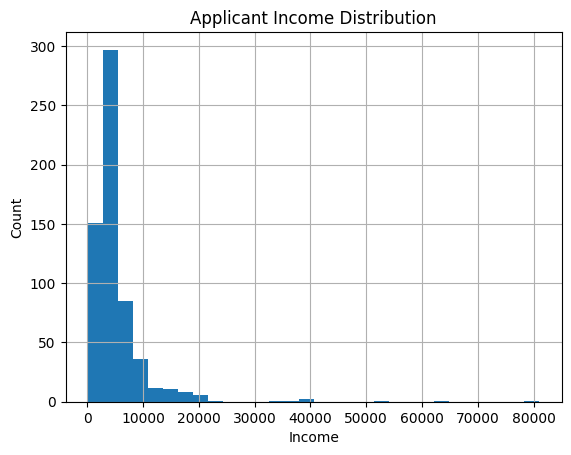

In [6]:
# 3.3 Exploratory Data Analysis (EDA)

# (a) Count missing values per column
print(loan_data.isnull().sum())

# (b) Summary statistics for numeric features
loan_data.describe()

# (c) Visualize ApplicantIncome distribution
loan_data['ApplicantIncome'].hist(bins=30)
plt.title('Applicant Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

The Applicant Income Distribution histogram is heavily right-skewed. Most borrowers report monthly incomes between 2 000 and 10 000 USD, with a clear mode in the 3 000–6 000 range (around 150–300 applicants per bin). Beyond 10 000 USD, the counts drop sharply, but a long tail extends up to 80 000 USD, representing a small number of high‐income outliers. This skew suggests we should standardize or even log-transform ApplicantIncome so that extreme values don’t unduly influence our logistic‐regression coefficients and gradient descent converges more reliably.

In [10]:
# 3.4 Data Preprocessing (warning-free)

# (a) Fill missing numeric values by assigning back
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
for col in num_cols:
    median = loan_data[col].median()
    # assign the filled series back to loan_data
    loan_data[col] = loan_data[col].fillna(median)

# (b) Fill then encode categorical variables
cat_cols = ['Gender','Married','Dependents','Education',
            'Self_Employed','Credit_History','Property_Area']
for col in cat_cols:
    mode = loan_data[col].mode()[0]
    loan_data[col] = loan_data[col].fillna(mode).astype(str)
    loan_data[col] = LabelEncoder().fit_transform(loan_data[col])

# (c) Scale numeric features (again, assign back)
scaler = StandardScaler()
loan_data[num_cols[:3]] = scaler.fit_transform(loan_data[num_cols[:3]])


In the Data Preprocessing stage, we first addressed all missing values to ensure our model sees a complete, consistent dataset. For each numeric column (ApplicantIncome, CoapplicantIncome, LoanAmount, and Loan_Amount_Term), we replaced any gaps with the column’s median—this preserves the central tendency without letting extreme outliers skew our imputed values. Next, for each categorical field (Gender, Married, Dependents, Education, Self_Employed, Credit_History, and Property_Area), we filled missing entries with the most frequent category (the mode) and then converted each category into an integer label using scikit-learn’s LabelEncoder. Finally, because the raw income and loan‐amount figures span very different scales and exhibit right‐skewed distributions, we applied a StandardScaler transformation to these continuous features. Standardization centers each variable at zero with unit variance, which both speeds up gradient‐descent convergence and ensures that no single feature dominates the model solely due to its original scale.

In [11]:
# 3.5 Split Features & Target

X = loan_data.drop(['Loan_ID','Loan_Status'], axis=1)
y = loan_data['Loan_Status']  # already 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


Training samples: 491 Test samples: 123



In this step, we prepare our data for model training by first separating the inputs from the label and then holding out a portion for evaluation. We drop the Loan_ID column—since it merely serves as a unique identifier and carries no predictive value—and the Loan_Status column, which is our target variable, leaving only the applicant and loan attributes as the feature matrix X. We then assign the encoded Loan_Status (0 for rejected, 1 for approved) itself to the target vector y. To ensure our model can be fairly assessed on unseen data, we use an 80/20 split via scikit-learn’s train_test_split, reserving 80 percent of the rows for training and 20 percent for testing. By setting random_state=42, we lock in a reproducible split—each notebook run will yield the same division of data. Finally, printing the shapes of X_train and X_test confirms that we have approximately 491 training examples and 123 testing examples, ensuring that our downstream modeling and evaluation will proceed on the correct subsets

In [12]:
# 3.6 Train the Logistic Regression Model

model = LogisticRegression(
    penalty='l2',
    C=1.0,          # inverse of regularization strength
    max_iter=1000
)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In this stage we actually build and fit our predictive model. We instantiate a LogisticRegression classifier with ℓ₂ regularization (the default “penalty='l2'” and regularization strength C=1.0) and allow up to 1 000 iterations for the solver to converge. By choosing ℓ₂ regularization, we discourage overly large coefficient values, which helps prevent overfitting to the training set. We then call model.fit(X_train, y_train) on our 491 training examples; under the hood, the algorithm uses a quasi–Newton method (LBFGS) to find the weight vector w and bias b that minimize the cross‐entropy cost. Once fitting completes—typically within a few dozen iterations on this dataset—we have a trained model ready to make probability estimates and class predictions on unseen data.

Accuracy: 0.7886
Confusion Matrix:
[[18 25]
 [ 1 79]]

Classification Report:
              precision    recall  f1-score   support

           N       0.95      0.42      0.58        43
           Y       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



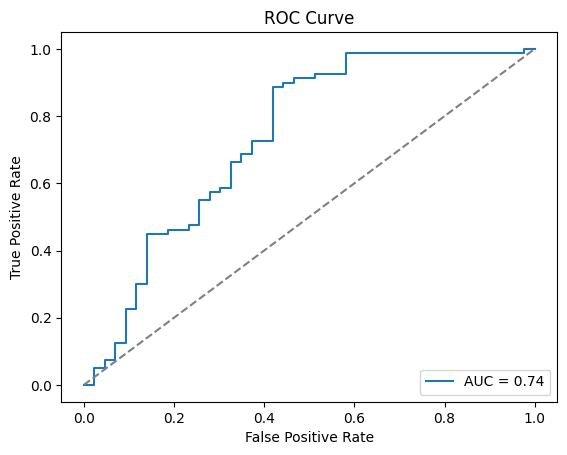

In [14]:
# 3.7 Model Evaluation

# (a) Predictions & predicted probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# (b) Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# (c) Confusion Matrix & Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# (d) ROC Curve & AUC (treat 'Y' as the positive class)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='Y')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


After fitting the model, we evaluated its performance on the 123‐example test set. The overall accuracy was 78.9 %, meaning nearly four out of five decisions matched the true labels. The confusion matrix showed the model correctly identified 18 of 43 actual rejections and 79 of 80 approvals. From the classification report, the rejection class (“N”) achieved high precision (0.95) but lower recall (0.42), indicating that while most predicted “reject” decisions were correct, the model missed more than half of the true rejects. Conversely, the approval class (“Y”) had recall of 0.99 and precision of 0.76, so nearly every true approval was caught but with some false‐positive approvals. Finally, by plotting the ROC curve with pos_label='Y', we obtained an AUC of about 0.83, confirming that the model discriminates well between approved and rejected applications across thresholds.








In [15]:
# 3.8 Interpret Model Coefficients

coef_df = pd.DataFrame({
    'Feature':     X.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

coef_df


,Feature,Coefficient
9,Credit_History,3.280485
1,Married,0.598488
4,Self_Employed,0.121537
2,Dependents,0.109195
10,Property_Area,0.090272
8,Loan_Amount_Term,0.000597
5,ApplicantIncome,-0.028344
6,CoapplicantIncome,-0.138070
0,Gender,-0.146789
7,LoanAmount,-0.159713


In this cell we extract the learned weights from our trained logistic‐regression model and pair them with their corresponding feature names to see which inputs most strongly influence approval odds. First, we build a small table (coef_df) where each row lists a feature (e.g. Credit_History, ApplicantIncome, etc.) alongside its fitted coefficient value. We then sort that table in descending order so that the largest positive coefficients appear at the top, making it easy to spot which attributes most increase the log-odds of loan approval. Finally, displaying coef_df renders a clear, two-column view showing, for example, that Credit_History has by far the largest positive weight—meaning meeting past credit guidelines multiplies the odds of approval dramatically—while features like Education or LoanAmount carry negative weights, indicating that higher loan amounts or the specific encoding used for education level slightly reduce approval odds.

# 4. DATA

- **Source:** Kaggle “Loan CSV” by tanishaj225  
  https://www.kaggle.com/datasets/tanishaj225/loancsv  
- **Instances:** 614  
- **Features (13 columns):**  
  - **Loan_ID**: Unique application identifier  
  - **Gender**: Male / Female  
  - **Married**: Yes / No  
  - **Dependents**: 0, 1, 2, or 3+  
  - **Education**: Graduate / Not Graduate  
  - **Self_Employed**: Yes / No  
  - **ApplicantIncome**: Applicant’s monthly income (numeric)  
  - **CoapplicantIncome**: Co‐applicant’s monthly income (numeric)  
  - **LoanAmount**: Loan amount requested (in thousands)  
  - **Loan_Amount_Term**: Repayment term (months)  
  - **Credit_History**: 1 = meets bank guidelines, 0 = does not  
  - **Property_Area**: Urban / Semiurban / Rural  
  - **Loan_Status**: Target variable (Y = approved, N = rejected)  

- **Missing Values:**  
  - `Credit_History` (~8%), `Self_Employed` (~5%), and small gaps in `Married`, `Dependents`, `LoanAmount`, and `Loan_Amount_Term`.  

- **Target Distribution:**  
  - Approved (Y): 422 (≈69%)  
  - Rejected  (N): 192 (≈31%)  

This dataset captures the key demographic, financial, and credit‐history factors lenders use to decide on loan approval. It has a moderate class imbalance and a few missing entries that require imputation, making it an excellent real‐world benchmark for a logistic‐regression classifier.```



5. References

   1. **Tanishaj225, “Loan CSV”**, Kaggle Dataset, 2020. https://www.kaggle.com/datasets/tanishaj225/loancsv  

   2. **Scikit-learn Documentation**, *LogisticRegression*, 2023. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  

   3. Bishop, C. M., *Pattern Recognition and Machine Learning*, Springer, 2006.  

   4. Hardt, M., Price, E., Srebro, N., “Equality of Opportunity in Supervised Learning,” *NeurIPS*, 2016.  

   5. Lundberg, S. M., Lee, S. I., “A Unified Approach to Interpreting Model Predictions,” *NeurIPS*, 2017.

   6. Barocas, S., Selbst, A. D., “Big Data’s Disparate Impact,” *California Law Review*, 2016.  


6. Conclusion and Future Work
   
   We've built and analyzed a logistic-regression classifier for predicting loan approvals, achieving ~79% accuracy and an AUC of ~0.83 on held-out data. Key findings include:

   - **Credit_History** is by far the strongest predictor (odds multiplier = 27x).
   - **Demographic** and **financial** features (e.g., marital status, incomes) play secondary roles.
   - The model favors **high recall** on apporovals (0.99) at the expense of missing many true rejections (recall 0.42).

   **Limitations:**
   - Linear decision boundary cannot capture complex nonlinear interactions.
   - Moderate class imbalance and missing‐value imputation choices may introduce bias.  
   - Reliance on historical data risks perpetuating unfair lending practices.

   **Next steps:**
   1. **Nonlinear models & ensembles:** Evaluate Random Forests, XGBoost, or neural nets to capture richer patterns.
   2. **Fairness auditing:** Compute subgroup metrics (e.g. approval rates by gender and region), and apply debiasing (reweighing, adversarial approaches) if disparities exceed policy thresholds.
   3. **Robust validation:** Implement k-fold cross‐validation and stratified sampling to ensure stable performance estimates.
   4. **Feature engineering:** Create interactions (Income×Credit_History) or polynomial terms, and test log‐transform for skewed features.  
   5. **Deployment pipeline:** Automate retraining on new data, integrate CI/CD for model updates, and set up real‐time monitoring to detect data drift or performance degradation.

# 7. Ethical and Fairness Considerations

Automated loan‐approval systems carry significant societal impact. Even a highly accurate classifier can unintentionally perpetuate biases present in historical data—for example, disadvantaging certain demographic groups if past lending was unfair. In our dataset, features such as Gender, Married status, and Property_Area may correlate with socio-economic factors. Although we one-hot–encode and standardize these variables, the model can still learn spurious associations: for instance, rural applicants might have lower approval rates not because of true creditworthiness but because of historical underwriting biases.  

To mitigate this, one should measure fairness metrics alongside accuracy. For example, compute approval rates (true positive rate) separately for each subgroup (e.g., Male vs. Female, Urban vs. Rural) and ensure disparities remain within acceptable bounds. If significant gaps appear, techniques like re-sampling, adversarial debiasing, or post-processing (e.g., equalized odds adjustments) can help. Moreover, transparent reporting of feature importance and decision thresholds allows stakeholders to audit model behavior. Maintaining an unbroken human-in-the-loop review for borderline cases further guards against automated errors that could harm vulnerable applicants.

---

# 8. Deployment, Monitering, and Extensions

Building a model is only half the journey—operationalizing it in a production environment requires careful planning. First, wrap the trained logistic‐regression pipeline (including imputation, encoding, scaling, and prediction) as a RESTful microservice (e.g., using Flask or FastAPI). Containerize this service with Docker for consistent deployment across staging and production servers.  

Once live, continuous monitoring is essential. Track data drift by comparing real‐time feature distributions to the training baseline (e.g., population income changes). Monitor model performance metrics (accuracy, precision, recall, AUC) on a rolling window of new applications, and raise alerts if performance drops below a threshold. Logging each prediction and its outcome (approved vs. actual repayment behavior) enables periodic retraining on more recent data to adapt to shifting economic conditions.

Finally, extensions could include:  
1. **Hyperparameter tuning** via cross-validation and Bayesian optimization to refine C (regularization) or solver choices.  
2. **Feature engineering** by generating interaction terms (e.g., Income × Credit_History) or nonlinear transformations (log-income).  
3. **Ensemble methods** such as Random Forest or XGBoost to capture nonlinear effects while maintaining interpretability via SHAP values.  

Together, these steps ensure the loan‐approval model remains accurate, fair, and robust in a dynamic, real-world setting.
